# In-Class Assignment - Decision Trees and Cross Validation

In this notebook, we will explore how to use Scikit-Learn's DecisionTreeClassifier models to build decision trees for both classification tasks.

What are the advantages of decision trees?
- Interpretability 
- Simplicty 
- Can handle both regression and classification tasks 

Disadvantages:
- Prone to overfitting with increasing depth, especially with more features
- You need careful feature selection to really take advantage of the advantages (e.g. interpretability)

We are going to use synthetically generated data (noiseless and noisy time series data) to explore decision trees. 


### Afterwards: Read the Docs

[Scikit-Learn Decision Tree User Guide](https://scikit-learn.org/stable/modules/tree.html)

[Scikit-Learn DecisiontTreeClassifier Doc Page](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

[Scikit-Learn DecisionTreeRegressor Doc Page](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor)

## Part 1: Generating Synthetic Data

One way to explore how decision trees perform is to create some toy problems where we an reason about how the classifier/regressor is behaving. 

**THE TASK: SUPERVISED CLASSIFICATION**

Our task is to construct a model which predicts the frequency of a sine wave, which is given to the model as a time-series.

**THE (LABLED) DATASET**

Our dataset will consist of several sine waves, sampled over $N$ points. The label for each sine wave is its **frequency**, which will be in the range $1, 2, ..., 9, 10$ Hz. Our sine waves may or may not contain Gaussian noise applied to each sample. 

**THE MODEL**

We will use a decision tree classifier and explore how the depth of the decision tree relates to the performance of the classifier.



In [0]:
import numpy as np
import matplotlib.pyplot as plt

### Generating Sine Waves

First we need a function to generate example sine waves. We will fix our number of "samples" to a number $N$. The equation for the noiseless sine wave time-series is then given by:

$$ f(k) = \sin(\omega k/(2\pi))$$

If we have Gaussian noise of variance $\sigma^2$, then our time-series is given by:

$$ f(k) = \sin(\omega k/(2\pi)) + \epsilon_k$$

Where $\epsilon_k$ is sampled from $N(0,\sigma^2)$.

In [0]:
'''
Generate some synthetic sine-wave data.

We'll use a 2*pi period and build a function to generate the data at different 
frequencies.

'''
def build_sampled_sine_wave(frequency, noise_var = 0.0, num_points = 200):
    interval = 2*np.pi
    data_x = np.linspace(0, interval, num_points)*frequency
    data_y = np.sin(data_x)
    
    noise = np.random.randn(num_points)*np.sqrt(np.abs(noise_var))
    data_y = data_y + noise
    
    return data_x, data_y

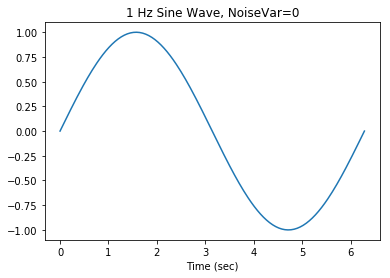

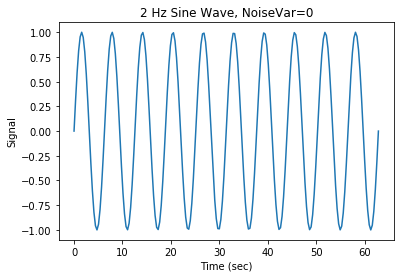

In [3]:
x, y = build_sampled_sine_wave(1, 0.0)
plt.plot(x, y)
plt.title("1 Hz Sine Wave, NoiseVar=0")
plt.xlabel("Time (sec)")
plt.ylabel("")
plt.show()
x, y = build_sampled_sine_wave(10, 0.0)
plt.plot(x, y)
plt.title("2 Hz Sine Wave, NoiseVar=0")
plt.xlabel("Time (sec)")
plt.ylabel("Signal")
plt.show()

Below, we've provided a function to build a dataset of sine waves with varying levels of noise.

We provide the function:

1. A list of frequencies
2. A list of noise variances

The function in turn provides us 10 samples for each combination of frequency and 
noise variance using the function from above.

In [0]:
from sklearn.model_selection import train_test_split

def build_sine_wave_dataset(frequencies, noise_levels, samples_per_cat=10):
    num_points = 200
    num_examples = len(frequencies)*len(noise_levels)*samples_per_cat
    noise_levels_test = noise_levels
    
    X_train = np.zeros((num_examples, num_points))
    X_test = np.copy(X_train)
    y_train = np.zeros((num_examples,), dtype=np.int32)
    y_test = np.copy(y_train)
    
    idx = 0
    for freq in frequencies:
        for sigma_n in noise_levels:
            for i in range(samples_per_cat):
                _, X_train[idx, :] = build_sampled_sine_wave(freq, sigma_n, num_points)
                if(noise_levels_test is None):
                    _, X_test[idx, :] = build_sampled_sine_wave(freq, sigma_n, num_points)
                    y_test[idx] = freq
                y_train[idx] = freq
                idx += 1
    
    idx = 0
    if(noise_levels_test is not None):
        for freq in frequencies:
            for sigma_n in noise_levels_test:
                for i in range(samples_per_cat):
                    _, X_test[idx, :] = build_sampled_sine_wave(freq, sigma_n, num_points)
                    y_test[idx] = freq
                    idx += 1
                    
    return X_train, X_test, y_train, y_test

In [5]:
freq_list = list(range(1,11))
noise_list = [0.001, 0.1, 1.0]

X_train, X_test, y_train, y_test = build_sine_wave_dataset(freq_list, noise_list)
print("Training data shape {}, training label shape {}".format(X_train.shape, y_train.shape))
print("test data shape {}, test label shape {}".format(X_test.shape, y_test.shape))

Training data shape (300, 200), training label shape (300,)
test data shape (300, 200), test label shape (300,)


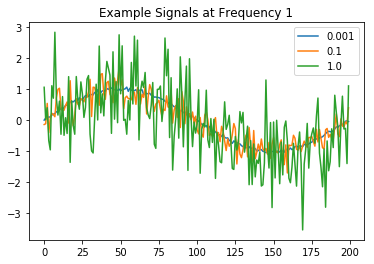

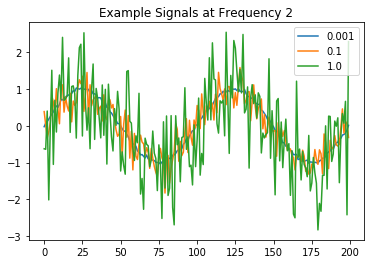

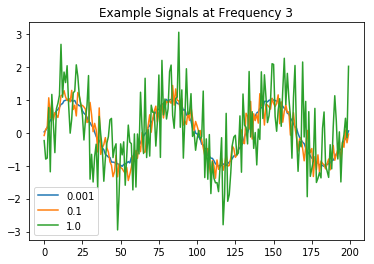

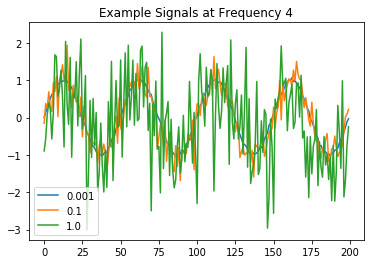

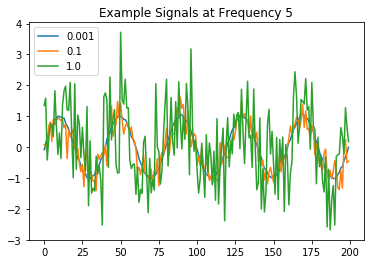

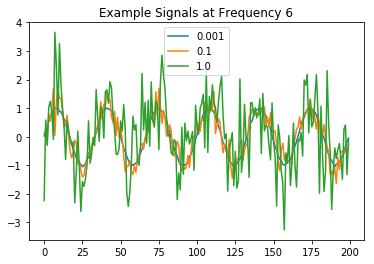

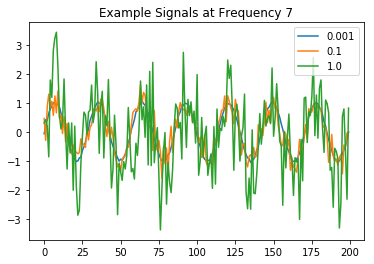

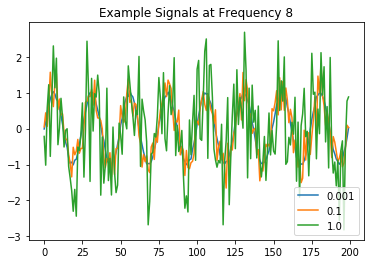

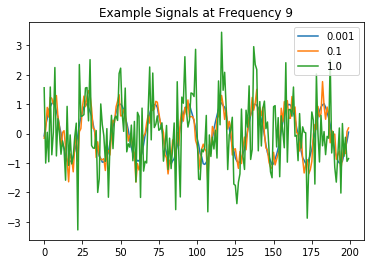

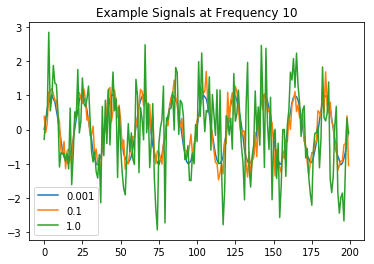

In [6]:
for idx, freq in enumerate(freq_list):
    plt.plot(X_train[idx*30:idx*30+30:10, :].T)
    plt.title("Example Signals at Frequency {}".format(freq))
    plt.legend(noise_list)
    plt.show()

## Discussion Points 

(First we'll discuss application)

We are now going to build a decision tree to classify the signals into different frequencies. The tree will see all of the above data, plus additional examples at each noise level. 

**Each signal has the same number of points (N=200), regardless of frequency.**

1. Discuss with your neighbors: For a set of frequencies 1,...,10 and no noise, how large is our dataset? What is the shape of the dataset array X_train? y_train? 
2. Discuss with your neighbors: **what features of the data will the decision tree use to classify this data**?: Make a concrete hypothesis. You can use the below figure to help reason about this.


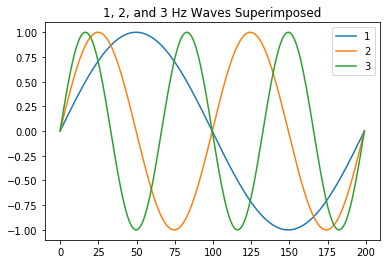

In [0]:
_, y1 = build_sampled_sine_wave(1, 0.0)
_, y2 = build_sampled_sine_wave(2, 0.0)
_, y3 = build_sampled_sine_wave(3, 0.0)

plt.plot(y1)
plt.plot(y2)
plt.plot(y3)

plt.title("1, 2, and 3 Hz Waves Superimposed")
plt.legend(["1", "2", "3"])
plt.show()

## Part 2: Building the Decision Tree Classifier

We will now write functions to:
- Build the DT classifier and fit to training data
- Evaluate DT classifier on test data

We will explore the DT classifier's performance related to an important hyperparameter - the maximum depth. 

### Discussion Points 

1. Discuss with your neighbors how the maximum depth of the decision tree will affect test set performance in a classification task **in general, not specific to this dataset**.

2. Recall that we are using the DT to classify the frequency of different sine waves that have varying levels of noise. **Make a concrete hypothesis regarding the relationship the depth of the classifier, test set performance, and . You must incorporate all 3 elements into your hypothesis**  

Write your hypothesis in this cell.

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix


def build_dt_class_model(data_X, data_y, max_depth = None):
    '''
    This function builds the decision tree classifier and 
    fits it to the provided data.
    
    Returns the trained DecisionTreeClassifier
    '''
    dt = DecisionTreeClassifier(criterion='entropy', max_depth = max_depth)
    dt.fit(data_X, data_y)
    
    return dt

In [0]:
def calc_acc(y_true, y_pred):
    '''
    This function calculates the accuracy given a vector of true labels
    and a vector of predicted labels. 
    
    Returns accuracy/100
    '''
    num_correct = np.sum(y_true == y_pred)
    acc = num_correct / y_true.shape[0]
    return acc

def eval_dt_class_model(dt_model, X_test, y_test):
    '''
    This function takes a trained DT classifier, 
    a test set, and evaluates the model. 
    
    Returns test accuracy and confusion matrix
    '''
    y_test_est = dt_model.predict(X_test)
    cm = confusion_matrix(y_test, y_test_est)
    return calc_acc(y_test, y_test_est), cm

#### Initial Exploration 1

For our first experiment, we will exclude noise. If we set the `max_depth` to `None`, then the decision tree will create as many levels as is required to perfectly classify the **training data**. 

Quick test: What should the **accuracy on the training set of the trained tree be?**

Quick test: What do you predict is the **accuracy on the test set?**


In [11]:
freq_list = list(range(1,11))
noise_list = [0.0]

X_train, X_test, y_train, y_test = build_sine_wave_dataset(freq_list, noise_list)
print("Training data shape {}, training label shape {}".format(X_train.shape, y_train.shape))
print("test data shape {}, test label shape {}".format(X_test.shape, y_test.shape))


dt_classifier = build_dt_class_model(X_train, y_train, None)

train_acc, train_cm = eval_dt_class_model(dt_classifier, X_train, y_train)

test_acc, test_cm = eval_dt_class_model(dt_classifier, X_test, y_test)

print("Training set accuracy: {}".format(train_acc))
print("Test set accuracy: {}".format(test_acc))
print("Test set confusion matrix: ")
print(test_cm)

print("Depth of model: {}".format(dt_classifier.get_depth()))


Training data shape (100, 200), training label shape (100,)
test data shape (100, 200), test label shape (100,)
Training set accuracy: 1.0
Test set accuracy: 1.0
Test set confusion matrix: 
[[10  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  0 10]]
Depth of model: 4


#### Initial Exploration 2

Now we will add noise. Return to the plots we made above of the noisy training data. Despite adding noise, we can easily see the frequency of the signal. **What will happen if we increase maximum noise**?

In [36]:
freq_list = list(range(1,11))
noise_list = [0.01, 0.1]

X_train, X_test, y_train, y_test = build_sine_wave_dataset(freq_list, noise_list,samples_per_cat=10)
print("Training data shape {}, training label shape {}".format(X_train.shape, y_train.shape))
print("test data shape {}, test label shape {}".format(X_test.shape, y_test.shape))

dt_classifier = build_dt_class_model(X_train, y_train, 4)

train_acc, train_cm = eval_dt_class_model(dt_classifier, X_train, y_train)

test_acc, test_cm = eval_dt_class_model(dt_classifier, X_test, y_test)

print("Training set accuracy: {}".format(train_acc))
print("Test set accuracy: {}".format(test_acc))
print("Test set confusion matrix: ")
print(test_cm)
print("Depth of tree: {}".format(dt_classifier.get_depth()))

Training data shape (200, 200), training label shape (200,)
test data shape (200, 200), test label shape (200,)
Training set accuracy: 1.0
Test set accuracy: 0.95
Test set confusion matrix: 
[[19  0  0  0  0  1  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0]
 [ 0  0 18  0  0  0  0  0  2  0]
 [ 0  1  0 17  0  2  0  0  0  0]
 [ 0  0  1  0 19  0  0  0  0  0]
 [ 0  0  0  0  0 20  0  0  0  0]
 [ 2  0  0  0  0  0 18  0  0  0]
 [ 0  0  0  0  0  0  0 19  0  1]
 [ 0  0  0  0  0  0  0  0 20  0]
 [ 0  0  0  0  0  0  0  0  0 20]]
Depth of tree: 4


#### Initial Exploration 3

What did the tree learn? We can plot the tree by using the Scikit-learn `plot_tree` function. Discuss with your neighbor how to interpret the below plot:




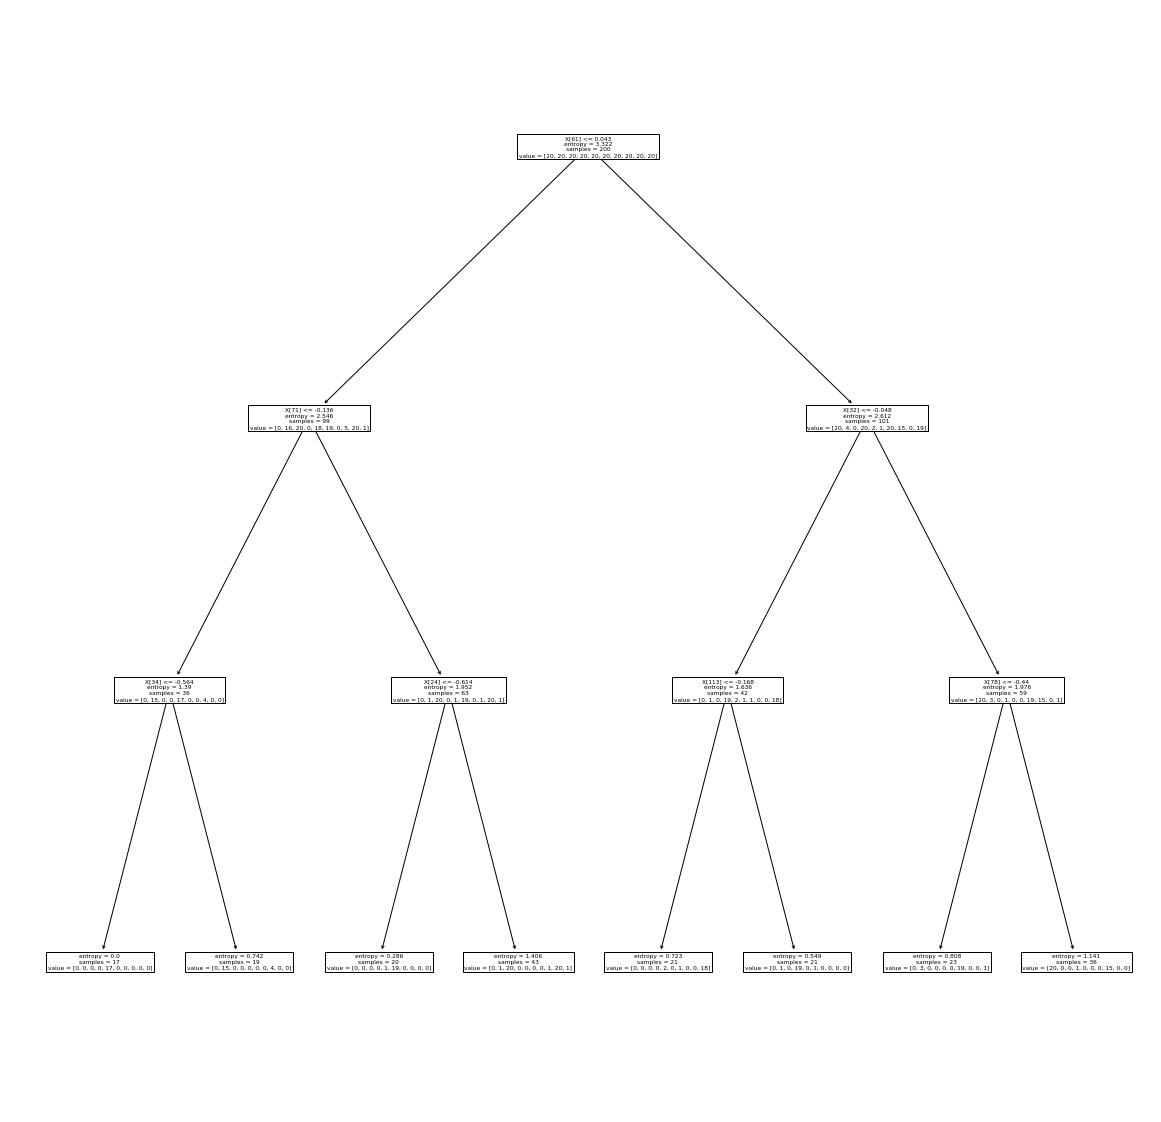

In [18]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20,20))
plot_tree(dt_classifier)
plt.show()

## Part 3: Parameter Selection using Cross Validaiton
For our first experiment, we will keep the noise levels the same accross both training and test sets. We will vary the depth of the decision tree and select the parameter based on validation performance. 

Here we will use **k-fold cross validation** as implemented by Scikit-Learn's [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) model. 

Our validation scheme is essentially this: 

1. Split our training set into $|V|$ equally sized  sets.
2. Select a range of values for our `max_depth`, for example 1 to 10. 
3. For each `max_depth` value, build a model. Then, fit the model to all but one of the $|V|$ splits. Then test the performance of the model (accuracy) on the held out split. Do this $|V|$ times for each split.

### Discussion points:

1. Why use k-fold cross validation? Is there an advantage of k-fold cross validation versus splitting a validation set off of the training or test set? Can we just use the test set for selecting parameter values? Are there any disadvantages to k-fold cross validation?

2. At the end of this validation process, how many accuracy scores will we have? 

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

In [0]:
# The max depth of our decision tree
# We will test models for max_depth = 1, ..., 40
depths = list(range(1,20,4))

# Our dataset will have frequencies 1, ..., 10
freq_list = list(range(1,21,2))

# We will have the following noise levels for each frequency:
noise_list = [0.1, 1.0, 2.0]

# Build and shuffle our dataset
X_train, X_test, y_train, y_test = build_sine_wave_dataset(freq_list, noise_list, samples_per_cat=100)
X_train, y_train = shuffle(X_train, y_train)

# The number of splits of our training data will be 10
cv_splits = 2

In [42]:
# Create an array to hold all of our cross validaiton scores
kval_scores = np.zeros((len(depths), cv_splits))

# Perform cross validation for each value of max_depth
for idx, max_depth in enumerate(depths):
    dt_classifier = build_dt_class_model(X_train, y_train, max_depth)
    kval_scores[idx, :] = cross_val_score(dt_classifier, X_train, y_train, cv=cv_splits)
    print("Scores at depth {}: {}".format(max_depth, kval_scores[idx, :]))

Scores at depth 1: [0.17266667 0.17466667]
Scores at depth 5: [0.61333333 0.63266667]
Scores at depth 9: [0.66066667 0.66666667]
Scores at depth 13: [0.65       0.65466667]
Scores at depth 17: [0.64733333 0.67266667]


We now have a set of $|V|$ scores for each `max_depth` value. How do we analyze these scores? See the plot below:

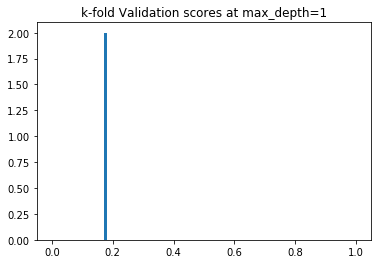

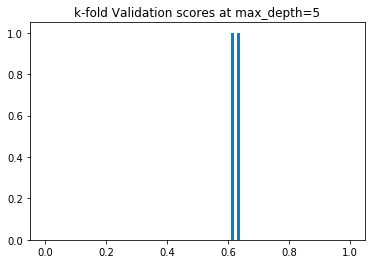

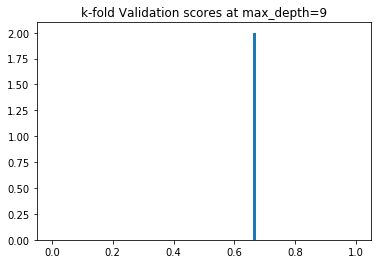

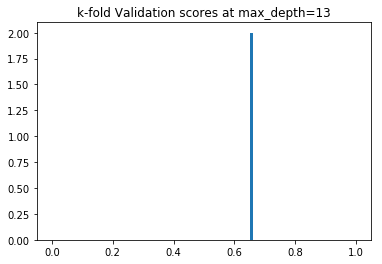

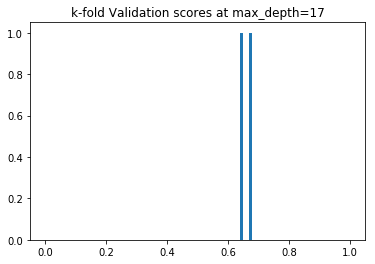

In [43]:
for idx, d in enumerate(depths):
    plt.hist(kval_scores[idx,:], bins=100, range=(0.0, 1.0))
    plt.title("k-fold Validation scores at max_depth={}".format(d))
    plt.show()

Let's inspect the mean and standard deviation for each `max_depth` value:

In [44]:
for idx, d in enumerate(depths):
    print("Accuracy: %0.2f (+/- %0.2f)" % (kval_scores[idx, :].mean(), kval_scores[idx, :].std() * 2))

Accuracy: 0.17 (+/- 0.00)
Accuracy: 0.62 (+/- 0.02)
Accuracy: 0.66 (+/- 0.01)
Accuracy: 0.65 (+/- 0.00)
Accuracy: 0.66 (+/- 0.03)


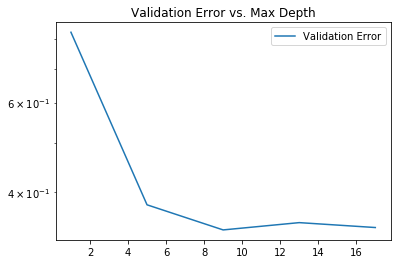

In [45]:
plt.semilogy(depths, 1-kval_scores.mean(axis=1))
plt.title("Validation Error vs. Max Depth")
plt.legend(["Validation Error"])
plt.show()

## Construct the final classifier 

Since we identified our parameter `max_depth` value via cross validation, we can now re-train our model using that parameter. This time, however, we should re-train using the entire dataset.

In [46]:
max_depth = None
dt_classifier = build_dt_class_model(X_train, y_train, max_depth)
test_acc, test_cm = eval_dt_class_model(dt_classifier, X_test, y_test)

print("Test set accuracy: {}".format(test_acc))
print("Test set confusion matrix: ")
print(test_cm)
print("Depth of tree: {}".format(dt_classifier.get_depth()))

Test set accuracy: 0.6906666666666667
Test set confusion matrix: 
[[198   9  13   6  15   5  12  13  16  13]
 [ 13 201   8  12  12   8   6  19   5  16]
 [ 15   7 210  10   6   7  14   8  15   8]
 [ 15  13   9 211   8  11   6   7   7  13]
 [  8  11   7  10 212   5  12  13  16   6]
 [ 11  16   8  14   9 198   4  13   8  19]
 [  5   7   6   6  19  13 209  15  16   4]
 [  8  13  10  12  11  13   4 198   8  23]
 [  8  10   6  12  15   5   9   9 217   9]
 [  9  12   3  14   5   6   8  18   7 218]]
Depth of tree: 11
